# Load Libraries and set global variables

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import torch
import utils
from datasets import load_dataset
from datetime import timedelta
from chronos import ChronosPipeline
from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TiDEModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller

TIME_COL = "Date"
TARGET = "visits"
STATIC_COV = ["static_1", "static_2", "static_3", "static_4"]
DYNAMIC_COV = ['CPI', 'Inflation_Rate', 'GDP']
FREQ = "MS"
FORECAST_HORIZON = 8 # months
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

# Load Data

In [11]:
# load data and exogenous features
df = pd.DataFrame(load_dataset("zaai-ai/time_series_datasets", data_files={'train': 'data.csv'})['train']).drop(columns=['Unnamed: 0'])
df[TIME_COL] = pd.to_datetime(df[TIME_COL])

print(f"Distinct number of time series: {len(df['unique_id'].unique())}")
df.head()

Distinct number of time series: 304


,Unnamed: 0,Date,unique_id,visits,CPI,Inflation_Rate,GDP,static_1,static_2,static_3,static_4
0,0,1998-01-01,AAAHol,2015.444457,67.4,0.009,3.996740e+11,A,A,A,Hol
1,1,1998-02-01,AAAHol,514.337600,67.4,0.009,3.996740e+11,A,A,A,Hol
2,2,1998-03-01,AAAHol,532.097470,67.4,0.009,3.996740e+11,A,A,A,Hol
3,3,1998-04-01,AAAHol,534.059083,67.4,0.009,3.996740e+11,A,A,A,Hol
4,4,1998-05-01,AAAHol,505.222272,67.4,0.009,3.996740e+11,A,A,A,Hol


# Split data between train and test

In [12]:
# 8 months to test
train = df[df[TIME_COL] <= (max(df[TIME_COL])-pd.DateOffset(months=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-pd.DateOffset(months=FORECAST_HORIZON))]

# read train and test datasets and transform train dataset
train_darts = TimeSeries.from_group_dataframe(
      df=train,
      group_cols=STATIC_COV,
      time_col=TIME_COL,
      value_cols=TARGET,
      freq=FREQ,  
      fill_missing_dates=True,
      fillna_value=0)

# since we have several time series not all of them have the same number of weeks in the forecast set
print(f"Months for training: {len(train[TIME_COL].unique())} from {min(train[TIME_COL]).date()} to {max(train[TIME_COL]).date()}")
print(f"Months for testing: {len(test[TIME_COL].unique())} from {min(test[TIME_COL]).date()} to {max(test[TIME_COL]).date()}")

Months for training: 220 from 1998-01-01 to 2016-04-01
Months for testing: 8 from 2016-05-01 to 2016-12-01


### Create covariates

In [13]:
# create dynamic covariates for each serie in the training darts
dynamic_covariates = []
for serie in train_darts:
    # add the month and week as a covariate
    covariate = datetime_attribute_timeseries(
        serie,
        attribute="month",
        one_hot=True,
        cyclic=False,
        add_length=FORECAST_HORIZON,
    )
    
    static_1 = serie.static_covariates['static_1'].item()
    static_2 = serie.static_covariates['static_2'].item()
    static_3 = serie.static_covariates['static_3'].item()
    static_4 = serie.static_covariates['static_4'].item()
    
    # create covariates to fill with interpolation
    dyn_cov_interp = TimeSeries.from_dataframe(df[(df['static_1'] == static_1) & (df['static_2'] == static_2) & (df['static_3'] == static_3) & (df['static_4'] == static_4)], time_col=TIME_COL, value_cols=DYNAMIC_COV, freq=FREQ, fill_missing_dates=True)
    covariate = covariate.stack(MissingValuesFiller().transform(dyn_cov_interp))

    dynamic_covariates.append(covariate)

# Forecast

## TiDE

In [ ]:
# scale covariates
dynamic_covariates_transformed = SCALER.fit_transform(dynamic_covariates)

# scale data and transform static covariates
data_transformed = PIPELINE.fit_transform(train_darts)

TiDE_params = {
    "input_chunk_length": 12, # number of months to lookback
    "output_chunk_length": FORECAST_HORIZON,
    "num_encoder_layers": 2,
    "num_decoder_layers": 2,
    "decoder_output_dim": 1,
    "hidden_size": 15,
    "temporal_width_past": 4,
    "temporal_width_future": 4,
    "temporal_decoder_hidden": 26,
    "dropout": 0.1,
    "batch_size": 16,
    "n_epochs": 15,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": True,
    "optimizer_kwargs": {"lr": 1e-3},
    "use_reversible_instance_norm": False,
}

model = TiDEModel(**TiDE_params)
model.fit(data_transformed, future_covariates=dynamic_covariates_transformed, verbose=False)
pred = PIPELINE.inverse_transform(model.predict(n=FORECAST_HORIZON, series=data_transformed, future_covariates=dynamic_covariates_transformed, num_samples=50))
tide_forecast = utils.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])

## Chronos

In [ ]:
# load model
pipeline_tiny = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

pipeline_large = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

# run forecast
forecast_tiny = []
forecast_large = []
for ts in train_darts:
    # tiny
    lower, mid, upper = utils.chronos_forecast(pipeline_tiny, ts.pd_dataframe().reset_index(), FORECAST_HORIZON, TARGET)
    forecast_tiny.append(utils.convert_forecast_to_pandas([lower, mid, upper], test[test['unique_id'] == list(ts.static_covariates_values())[0][0]+list(ts.static_covariates_values())[0][1]+list(ts.static_covariates_values())[0][2]+list(ts.static_covariates_values())[0][3]]))
    
    # large
    lower, mid, upper = utils.chronos_forecast(pipeline_large, ts.pd_dataframe().reset_index(), FORECAST_HORIZON, TARGET)
    forecast_large.append(utils.convert_forecast_to_pandas([lower, mid, upper], test[test['unique_id'] == list(ts.static_covariates_values())[0][0]+list(ts.static_covariates_values())[0][1]+list(ts.static_covariates_values())[0][2]+list(ts.static_covariates_values())[0][3]]))

# convert list to data frames
forecast_tiny = pd.concat(forecast_tiny)
forecast_large = pd.concat(forecast_large)

## Plot Actuals and Forecast

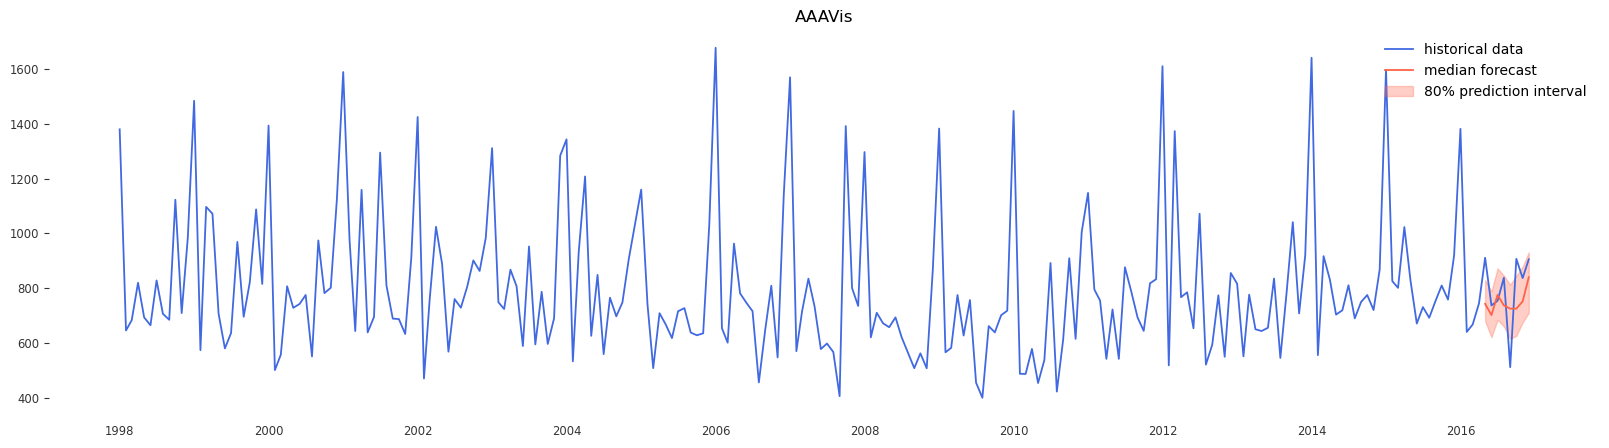

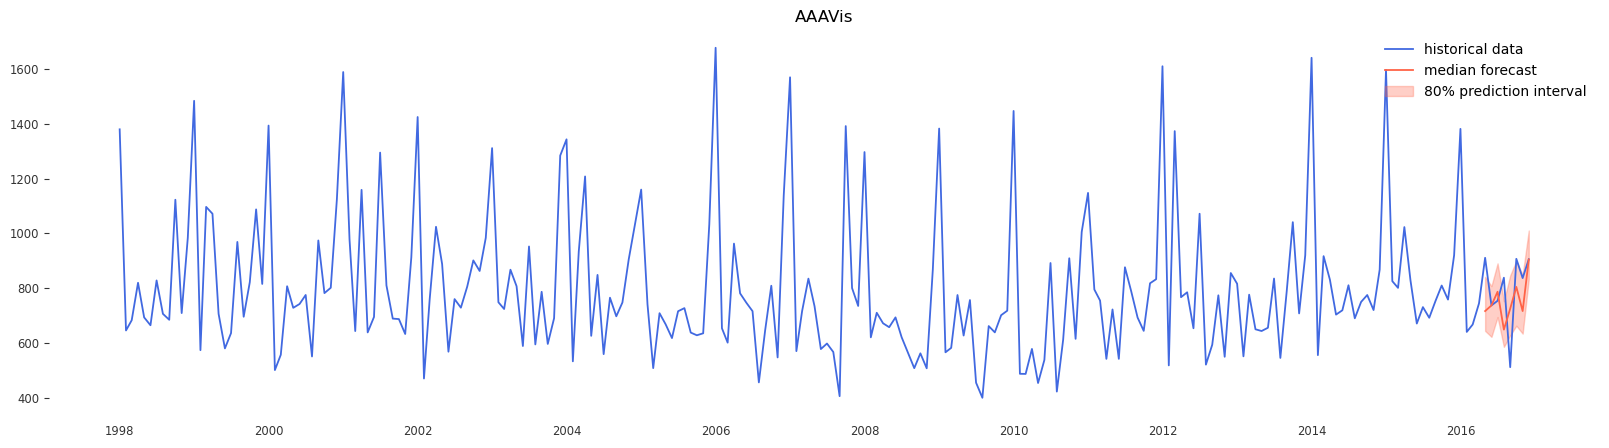

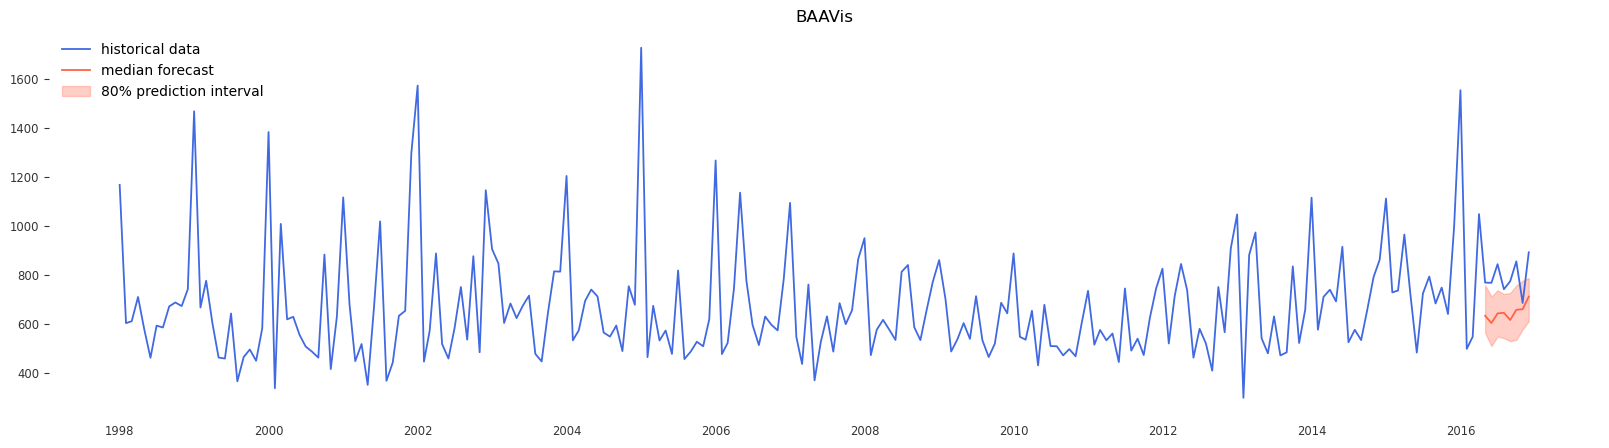

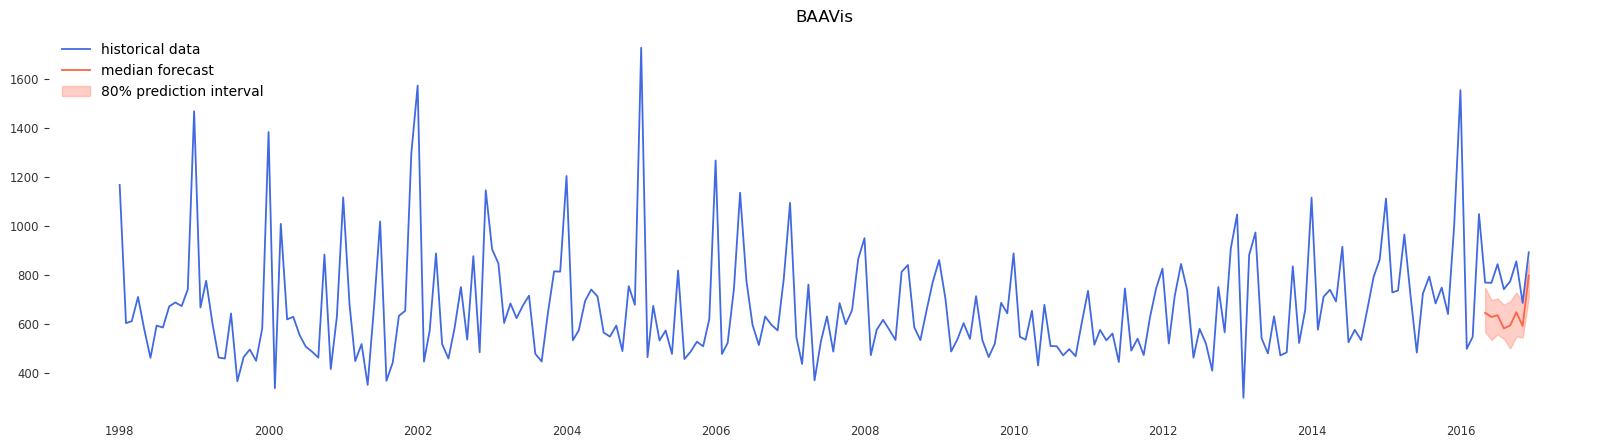

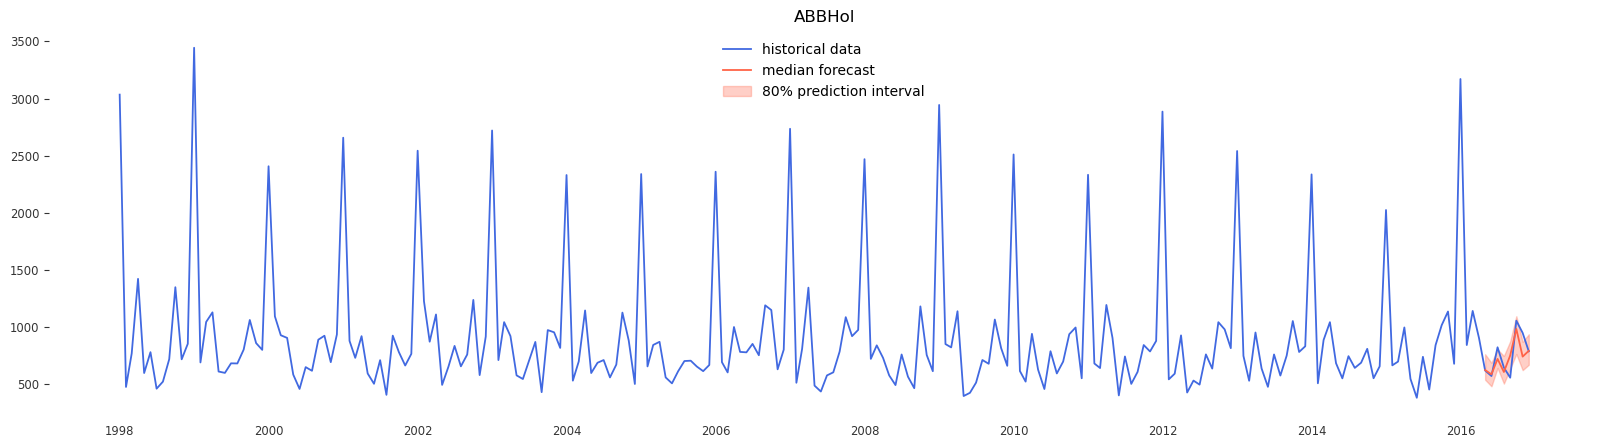

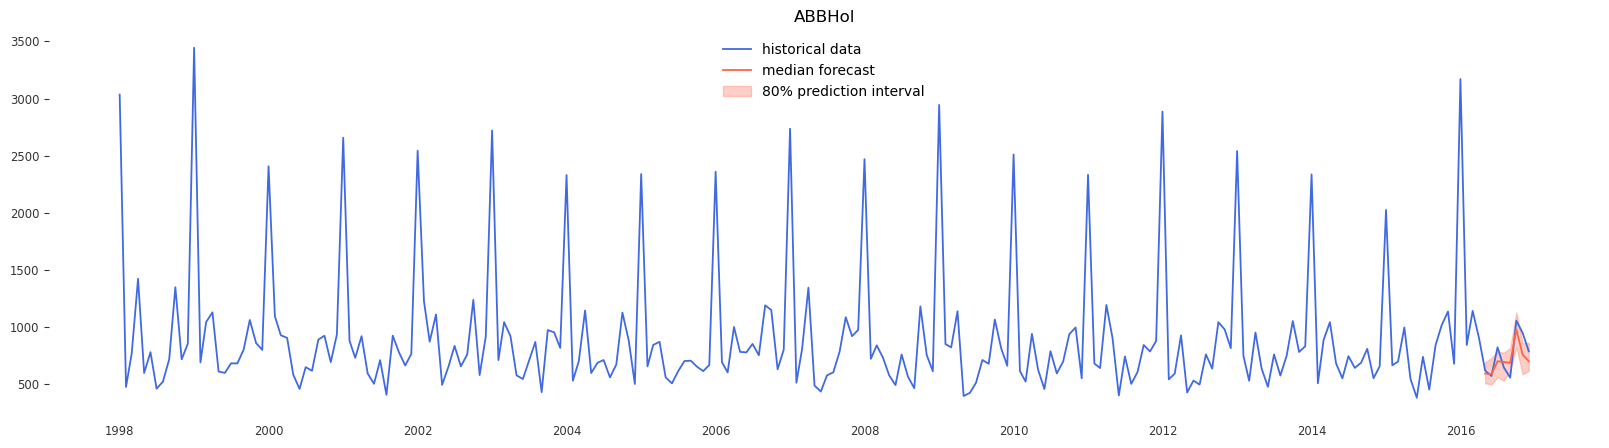

In [69]:
# get series ordered by volume in a descending way
series = test.groupby('unique_id')[TARGET].sum().reset_index().sort_values(by=TARGET, ascending=False)['unique_id'].tolist()

for ts in series[:3]:
    utils.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_tiny[forecast_tiny["unique_id"] == ts], ts)
    utils.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_large[forecast_large["unique_id"] == ts], ts)

# Model Evaluation

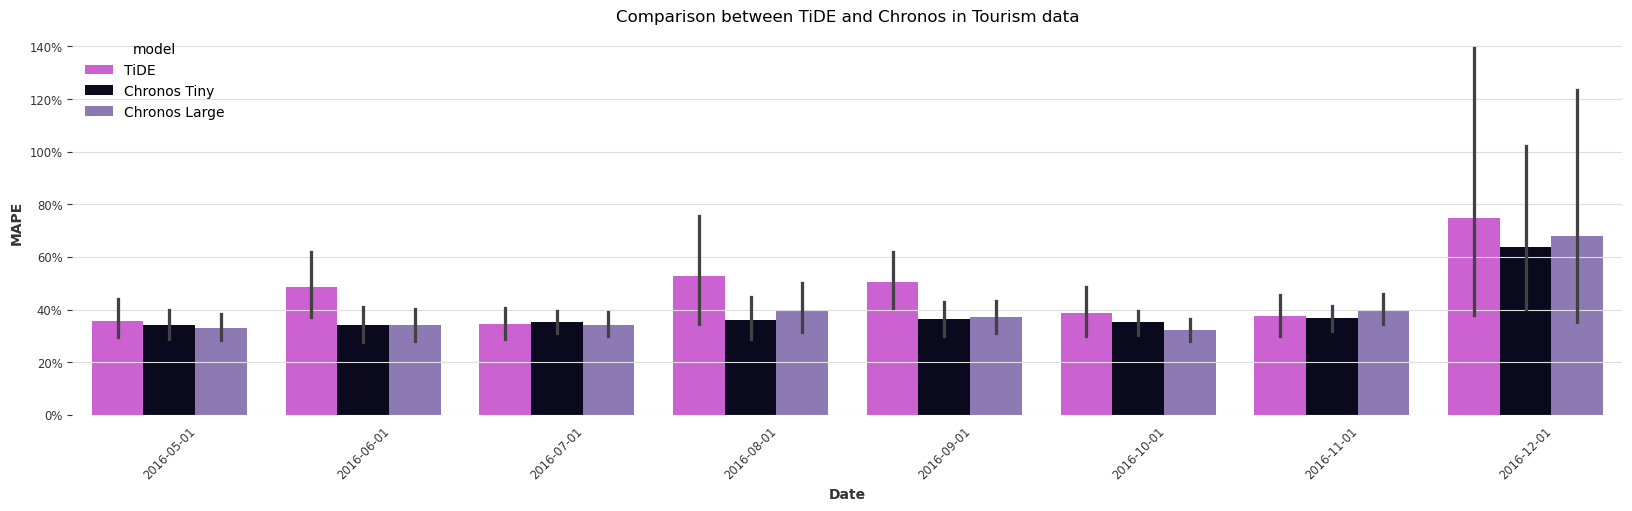

In [82]:
# load the forecast from our current model in production
tide_model_df = pd.read_csv('data/tide.csv', parse_dates=['Date'])
chronos_tiny_df = pd.read_csv('data/chronos_tiny.csv', parse_dates=['Date'])
chronos_large_df = pd.read_csv('data/chronos_large.csv', parse_dates=['Date'])

# merge data frames with forecast and actuals
model_eval_df = pd.merge(test[['unique_id', 'Date', TARGET]], tide_model_df[['unique_id', 'Date', 'TiDE']], on=['unique_id', 'Date'], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_tiny_df[['unique_id', 'Date', 'Chronos Tiny']], on=['unique_id', 'Date'], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_large_df[['unique_id', 'Date', 'Chronos Large']], on=['unique_id', 'Date'], how='inner')

# check performance for top 100 series
top_100 = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(100)

utils.plot_model_comparison(model_eval_df[model_eval_df['unique_id'].isin(top_100['unique_id'])])